![](../logo.png)

# Logistic regression
## Yoav Ram

Binary (or binomial) logistic regression is a statistical method used to model the relationship between a class label $y \in \{0,1\}$ and one or more independent variables (predictors, features, $x$) using a linear model (ProbML ch. 10).

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as np
import jax
from jax import random
from jax.scipy import stats, optimize
from jax.scipy.special import expit, logit
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
red, blue, green = sns.color_palette('Set1', 3)

# Data 

We will use the [Pima diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database), originally from the National Institute of Diabetes and Digestive and Kidney Diseases.

The data contains several physiological and demographic features from which we want to predict if the patient has diabetes.

In [21]:
df = pd.read_csv("../data/pima-diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Let's extract the features to $X=\{x_{i,j}\}_{i=1, j=1}^{n,m}$ and the target to $Y=(y_1, \ldots,y_n)$.
We also scale $X$ by substracting the feature (column) mean, $\bar{x}_j$ and dividing by feature standard deviation, $\sigma_j$, to get all features to the same range of value.
Scaling is done by
$$
\tilde{x}_{i,j} = \frac{x_{i,j} - \bar{x}_j}{\sigma_j}
$$

In [22]:
features = df.columns[:-1].tolist()
X = df[features].values
X = (X - X.mean(axis=0)) / X.std(axis=0) # scaling
Y = df['Outcome'].values

# Binary logistic regression
When there are only two class labels (e.g., 0 and 1; cat and dog), the model is known as **binary logistic regression** (if there are more, it is called multiple/multinomial logistic regression or sometimes softmax regression).

Let's write the model. 
Denote the number of individuals by $n$.
We assume that the outcome $y_i \in \{0,1\}$ of individual $i$ is **Bernoulli distributed** with probability $\hat{y}_i$.
We still have a linear model, but not directly for $\hat{y}_i$, because it is a probability and therefore constrained to be between 0 and 1. Instead, we assume that $z_i=\textit{logit}{(\hat{y}_i)}=\log{\frac{\hat{y}_i}{1-\hat{y}_i}}$ is a linear function of $m$ features, $x_i=(x_{i,1}, \ldots, x_{i,m})$, because $\textit{logit}{(\hat{y}_i)}$ can be any real number.

Thus,
$$
z_i = \sum_{j=1}^{m}{a_j x_{i,j}} $$$$
\log{\frac{\hat{y}_i}{1-\hat{y}_i}} = z_i $$$$
y_i \sim \text{Ber}(\hat{y}_i)
$$
Here,  $W = (a_1, \ldots, a_m)$ are the model parameters, also called weights or coefficients.
They determine the additive effect of a unit change in the features on the log-odds of the outcome, or the multiplicative effect on the odds of the outcome.

The inverse of the logit function is called the _expit_ or **logistic function**, and hence the name of the regression method;
$$
\hat{y_i} = \frac{1}{1+e^{-z_i}}
$$

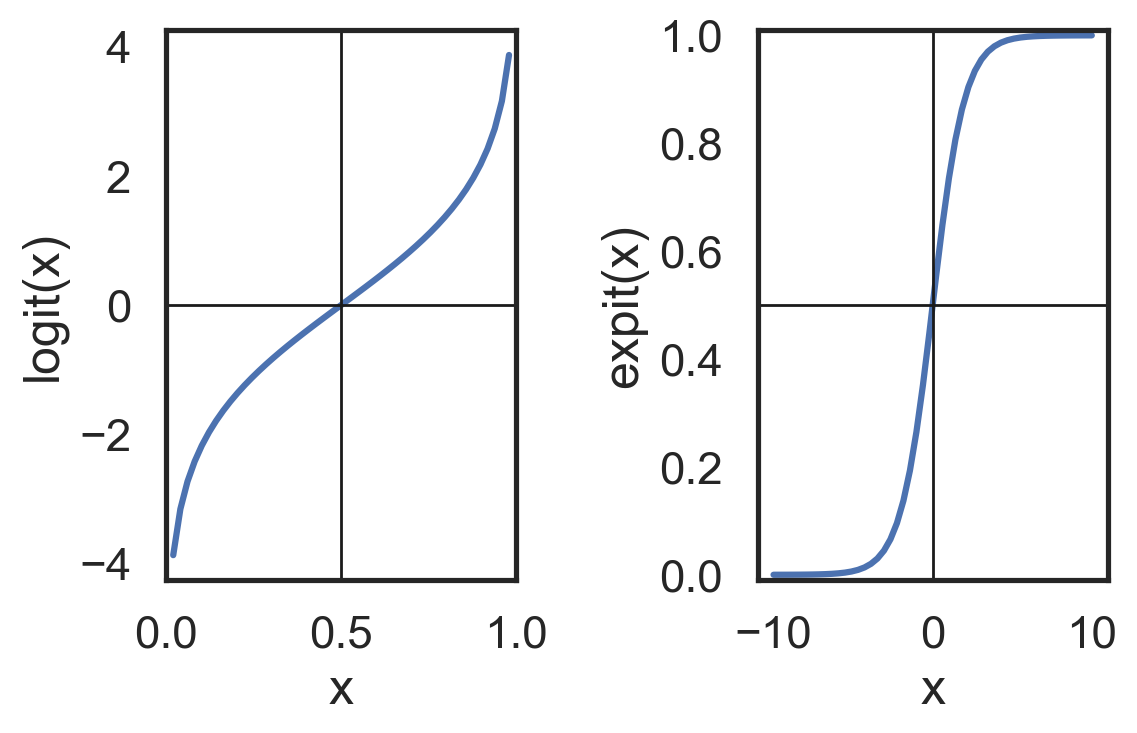

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
ax = axes[0]
x_range = np.linspace(0, 1)
ax.plot(x_range, logit(x_range))
ax.set(ylabel='logit(x)', xlabel='x', xlim=(0, 1))
ax.axhline(0, color='k', lw=1)
ax.axvline(0.5, color='k', lw=1)

ax = axes[1]
x_range = np.linspace(-10, 10)
ax.plot(x_range, expit(x_range))
ax.axvline(0, color='k', lw=1)
ax.axhline(0.5, color='k', lw=1)
ax.set(ylabel='expit(x)', xlabel='x', ylim=(-0.01, 1.01))

fig.tight_layout()

# Maximum likelihood estimation

From our model, the likelihood is 
$$
p(y_i \mid x_i, W) = \cases{\hat{y}_i, \quad y_i=1 \\ 1-\hat{y}_i, \quad y_i=0}
$$
where $W=(a_1, \ldots, a_m)$ are the model parameters that affect the likelihood via $\hat{y}_i=1/\left(1+\exp{\left(\sum_{j=1}^{m}{a_j x_{i,j}}\right)}\right)$.

This can also be written as 
$$
p(y_i \mid x_{i}, W) = \hat{y}_i^{y_i} \cdot (1-\hat{y}_i)^{1-y_i}
$$
Assuming $y_i, y_k$ are independent for all $i,k$,
$$
p(Y \mid X, W) = \prod_{i=1}^{n}{\hat{y}_i^{y_i} \cdot (1-\hat{y}_i)^{1-y_i}}
$$

Therefore, the negative log likelihood (which again makes sense because we have a product of exponents) is
$$
NLL(W) = -\frac{1}{n}\log\left(\prod_{i=1}^{n}{\hat{y}_i^{y_i} \cdot (1-\hat{y}_i)^{1-y_i}}\right) = 
-\frac{1}{n}\sum_{i=1}^{n}y_i \log{\hat{y}_i} + (1-y_i)\log{(1-\hat{y}_i)}
$$
where we scale by the dataset size $n$ so that we can compare values between datasets of different sizes.
This function is called in information theory the [**cross entropy**](https://en.wikipedia.org/wiki/Cross-entropy) function, and in the deep learning context this name has stuck.

Note that this function can be numerically unstable when $\hat{y}_i$ are close to zero or one. 
A different way to write it is
$$
NLL(W) = \frac{1}{n}\sum_{i=1}^{n}{z_i (1-y_i) + \log{\left(1+e^{-z_i}\right)}}
$$

## Exercise: cross entropy

Implement the negative log likelihood or cross entropy function.

In [24]:
def NLL(W, X, Y):
    Z = X @ W
    return (Z * (1-Y) + np.log(1 + np.exp(-Z))).mean()

In [25]:
W = np.linspace(0, 1, len(features))
print(NLL(W, X, Y))

0.7172282


# Gradients and the chain rule

To find the MLE we need to solve $\partial NLL / \partial W = 0$, which can be done using different gradient-based optimization algorithms. 
For that we need to derive the gradient (Prob ML ch. 10.2.3.3).

We will use the **[chain rule](https://en.wikipedia.org/wiki/Chain_rule)**:
$$
\frac{dx}{dy} = \frac{dx}{dz} \cdot \frac{dz}{dy}
$$

Remember that $z = a_1 x_1 + \ldots + a_m x_m$ and $\ell$ is the NLL function that we want to minimize.

Then for a single data example $(x, y)$,
$$
\frac{\partial NLL}{\partial a_j} = 
\frac{\partial NLL}{\partial \widehat y} \cdot \frac{\partial \widehat y}{\partial z} \cdot \frac{\partial z}{\partial a_j}
$$

So we have three terms. 
The easiest one is:
$$
\frac{\partial z}{\partial a_j} = x_j
$$

The derivative of the logistic (expit) function is (you can verify this):
$$
\frac{\partial \widehat y}{\partial z} = \widehat y ( 1-\widehat y )
$$

Next, because $\frac{\partial \log}{\partial x} = \frac{1}{x}$, 
$$
\frac{\partial NLL}{\partial \widehat y} = 
- \frac{\partial}{\partial \widehat y} \big(y \log{\widehat{y}} + (1-y) \log{(1-\widehat{y})}\big) = $$$$
-y \cdot \frac{1}{\widehat y} + (1-y) \cdot \frac{1}{1-\widehat y} = $$$$
\frac{\widehat y - y}{\widehat y ( 1 - \widehat y)}
$$

Putting it all together,
$$
\frac{\partial NLL}{\partial a_j} = 
\frac{\partial NLL}{\partial \widehat y} \cdot \frac{\partial \widehat y}{\partial z} \cdot \frac{\partial z}{\partial a_k} = $$$$
\frac{\widehat y - y}{\widehat y ( 1 - \widehat y)} \cdot \widehat y ( 1-\widehat y ) \cdot x_j = $$$$
(\widehat y - y) \cdot x_j
$$

This is pretty cool: it is the residual (i.e., difference between the predicted and oberverd probabilities, $\widehat y - y$), so 0 when the model got it right and 1 or -1 when it got it completely wrong, multiplied by the stength of the signal, so that strong signals (large $x_j$) have a stonger gradient and stonger effect on the result.

This was the gradient for a single sample. We average it over all samples to get a good estimate of the "real gradient" (law of large numbers etc.).

# Exercise: gradients

Implement a `gradient(W, X, Y)` function that returns the gradeint of `NLL` and compare it with `jax.grad(NLL)`.

In [27]:
def gradient(W, X, Y):
    Z = X @ W
    Yhat = expit(Z)
    δ = Yhat - Y    
    G = X.T @ δ / X.shape[0] # equivalent to G = (X * δ).mean(axis=0) 
    assert G.shape == W.shape
    return G

In [28]:
G = gradient(W, X, Y)
print(G)
assert np.allclose(G, jax.grad(NLL)(W, X, Y))

[-0.0195708  -0.08897007  0.09370636  0.11881358  0.08448488  0.03276872
  0.07697962  0.0561166 ]


# Gradient descent

The NLL function is convex (ProbML ch. 10.2.3.4), so all we need to do is follow the negative gradeints that we just calculated towards the global minimum; this is called **gradient descent**.

This is a simple, effective, and generic iterative algorithm.
In each step, we calculate that gradient of the NLL function with respect to model parameters $\partial \ell/\partial W$ and update the parameters according to the recursive equation for the parameter values at iteration $t$,
$$
W_t = W_{t-1} - \eta \frac{\partial NLL(W)}{\partial W}
$$
Here, $\eta$ is the size of the step we take in the negative gradient in each iteration, also called **learning rate**. 


In [29]:
def gradient_descent(W, X, Y, η):
    G = gradient(W, X, Y)
    ΔW = -η * G
    return W + ΔW

In [10]:
%timeit gradient_descent(W, X, Y, η=0.0001)

386 μs ± 28.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can pass the gradient descent function through `jax.jit`, which [just-in-time compiles the function](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html) so it can be executed efficiently in [XLA](https://openxla.org/xla).

On my machine this reduces running time ~10-fold.

In [30]:
%%time
gradient_descent = jax.jit(gradient_descent)
gradient_descent(W, X, Y, η=0.0001);

CPU times: user 61.3 ms, sys: 4.05 ms, total: 65.4 ms
Wall time: 46.3 ms


In [12]:
%timeit gradient_descent(W, X, Y, η=0.0001);

55.9 μs ± 4.89 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


So let's also do this for NLL.

In [11]:
%timeit NLL(W, X, Y)
NLL = jax.jit(NLL)
NLL(W, X, Y);
%timeit NLL(W, X, Y)

160 μs ± 2.56 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
32.4 μs ± 278 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Fitting the model

We are now ready to fit the model.
We initialize $W$ with all ones, since we know the problem is convex.

The `fit_logistic` function will do all the hard work.

In [33]:
def fit_logistic(X, Y, η=0.001, niter=100000, verbose=True):
    W = np.ones(X.shape[1])
    for t in range(niter+1):
        if t % 5000 == 0 and verbose:
            print("{:6d}: NLL={:.6f}, W={}".format(t, NLL(W, X, Y), np.array_str(W, precision=4)))
        W = gradient_descent(W, X, Y, η)        
    return W

W = fit_logistic(X, Y)

     0: NLL=0.949854, W=[1. 1. 1. 1. 1. 1. 1. 1.]
  5000: NLL=0.664917, W=[0.6965 0.9958 0.3551 0.3865 0.4997 0.7602 0.7352 0.6132]
 10000: NLL=0.554594, W=[ 0.4954  0.9659 -0.0277  0.0757  0.1719  0.6256  0.5307  0.3376]
 15000: NLL=0.534646, W=[ 0.411   0.9684 -0.1675 -0.0165  0.0128  0.5855  0.4158  0.2097]
 20000: NLL=0.531802, W=[ 0.3856  0.9918 -0.2105 -0.0276 -0.0578  0.5838  0.3629  0.1624]
 25000: NLL=0.531168, W=[ 0.3802  1.016  -0.2255 -0.0197 -0.0935  0.5882  0.3396  0.1444]
 30000: NLL=0.530936, W=[ 0.3806  1.0353 -0.2325 -0.0099 -0.1146  0.5914  0.3297  0.1364]
 35000: NLL=0.530831, W=[ 0.3823  1.0496 -0.2366 -0.0017 -0.1284  0.5928  0.3256  0.1319]
 40000: NLL=0.530778, W=[ 0.384   1.06   -0.2393  0.0046 -0.1379  0.5931  0.324   0.1291]
 45000: NLL=0.530751, W=[ 0.3854  1.0676 -0.2412  0.0093 -0.1446  0.593   0.3236  0.1271]
 50000: NLL=0.530737, W=[ 0.3866  1.0731 -0.2425  0.0128 -0.1494  0.5927  0.3236  0.1256]
 55000: NLL=0.530729, W=[ 0.3875  1.0771 -0.2434  0.0153 -

# Classification

When we use this model for classification we can use $\hat{y}_i>0$ (or $z>0$) as a classification rule if the loss for missclasification of each class is the same - which may be the case if the classes are "cat" and "dog" but may not be the case when the classes are "+" and "-" for a health condition.

In [34]:
def predict(W, X, th=0.5):
    Yhat = expit(X@W)
    return Yhat > th
    
predictions = predict(W, X)    
print(predictions[:10].astype(int))
print(Y[:10])

[1 0 1 0 1 0 0 1 1 0]
[1 0 1 0 1 0 1 0 1 1]


We can score the model by its **prediction accuracy**, which is the fraction of cases in which it makes the correct prediction.

In [35]:
score = (predictions == Y).mean()
print("Accuracy: {:.4f}".format(score))

Accuracy: 0.7461


This is the prediction accuracy on the **training set**: the data on which we trained the model.
But what we really care about is the prediciton accuracy on _unseen_ new data.
A common way to deal with that is to perform a **train-test split** of the data to training and testing sets. We sample 75% of the data to the training set and the rest to the test set. Then we fit on the training set and score on the test set!

In [36]:
key = random.key(2232)
key, subkey = random.split(key)
idx = random.uniform(key, shape=X.shape[0]) < 0.75
X_train, Y_train, X_test, Y_test = X[idx], Y[idx], X[~idx], Y[~idx]

In [37]:
W = fit_logistic(X_train, Y_train, verbose=False)

In [38]:
score_train = (predict(W, X_train) == Y_train).mean()
print("Train accuracy:\t{:.4f}".format(score_train))

score_test = (predict(W, X_test) == Y_test).mean()
print("Test accuracy:\t{:.4f}".format(score_test))

Train accuracy:	0.7530
Test accuracy:	0.7202


So our test accuracy is similar to the train accuracy.

We can check what kind of mistakes the model makes using a confusion matrix.
This matrix shows that mistaking "-" to "+" is more common than the other way around.
This is probably not as bad, as the people with "+" prediction will be tested and found "-".

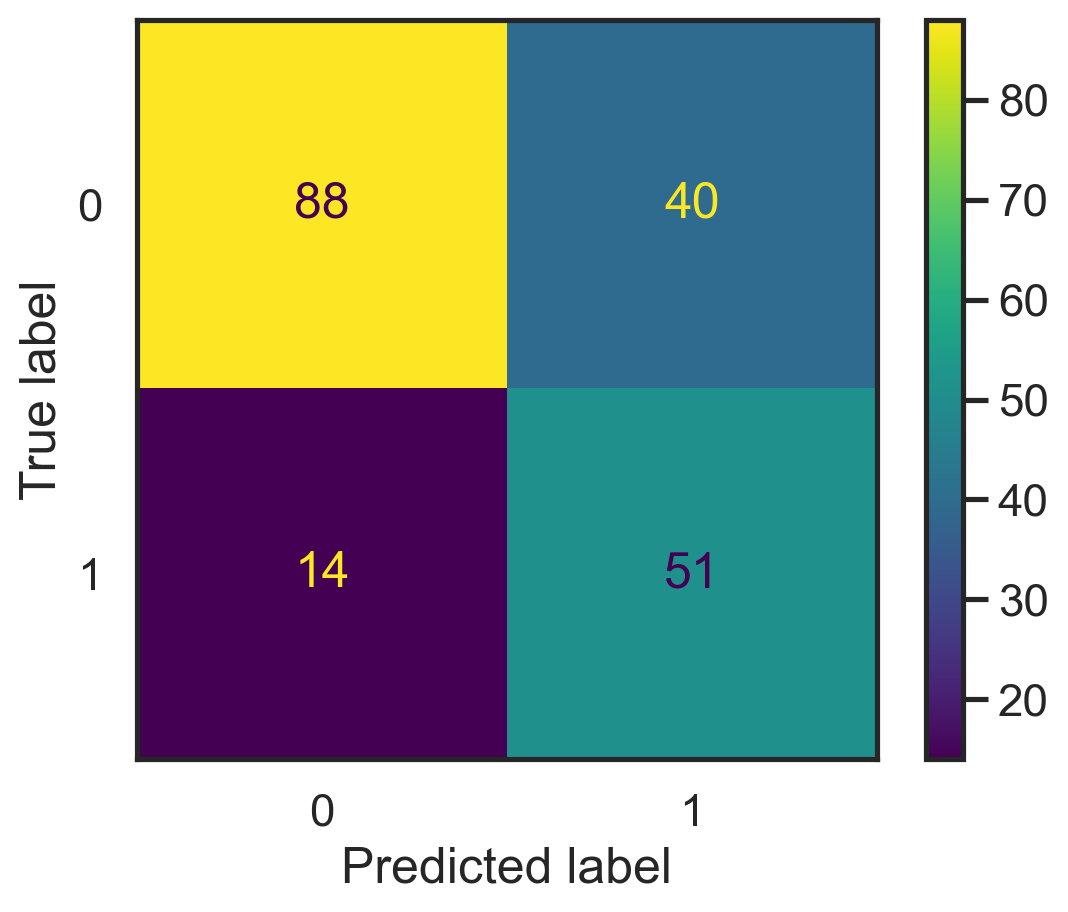

In [39]:
cm = confusion_matrix(Y_test, predict(W, X_test))
ConfusionMatrixDisplay(cm).plot();

The prediction threshold we pick can balance between the probability to give an incorrect positive answer and the probability to give a correct positive answer.
These are called the false-positive rate and true-positive rates.

You might consider that it is preferable to sometimes tell someone they are putatively positive and should be tested, rather than sometimes telling people they are negative and should go home when they are actually positive.

Let's plot the [receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve.

An "ideal" model will shoot directly to the top, that is, have maximum TPR for any FPR.
A "random" or "naive" model can be expected to follow the dashed line.

Indeed if we look at the ROC curve, the threshold we chose, 0.5, is right on the "knee" of the curve.

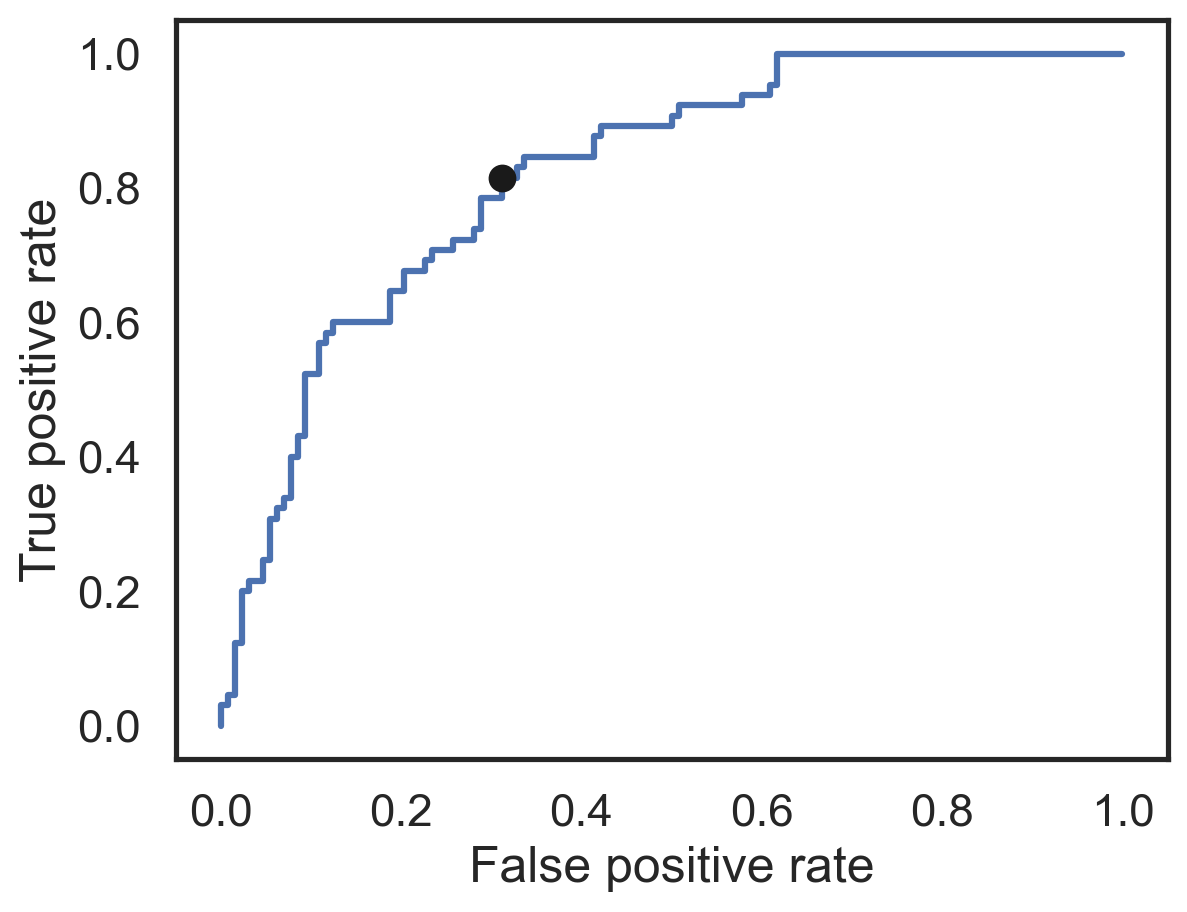

In [40]:
Yhat = expit(X_test@W)

fpr, tpr, thresholds = roc_curve(Y_test, Yhat)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
idx = (thresholds < 0.5).argmax()
plt.plot(fpr[idx], tpr[idx], 'ok');

# Logistic regression with Python libraries

## Scikit-learn

[Scikit-learn](http://scikit-learn.org/stable/index.html) is an awesone machine learning package with very good documentation.
Note that the package name is `sklearn`.

In [41]:
model = LogisticRegression(fit_intercept=False)
model.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.7202072538860104

## Statsmodels

[Statsmodels](http://statsmodels.sourceforge.net/) is also a good package, more oriented to statistics then machine learning.

Note that statsmodels uses a different method to find the maximum likelihood so it may be  faster.

In [42]:
X = df[features]
X = (X - X.mean(axis=0)) / X.std(axis=0) # scaling
Y = df['Outcome']

X_ = sm.add_constant(X)
logit = sm.Logit(Y, X_)
result1 = logit.fit()
Yhat = result1.predict(X_)
predictions = Yhat > 0.5
print("Accuracy: {:.4f}".format((predictions == Y).mean()))

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
Accuracy: 0.7826


In [43]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.2718
Time:                        16:40:12   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.8711      0.097     -8.986      0.000      -1.061      -0.681
Pregnancies                  0.4151      0.108      3.840      0.000       0.203       0.627
Glucose                      1.1243      0.119      9.481      0.000       0.892       1.357
BloodPressure               -0.2573      0.101     -2.540      0.011      -0.456      -0.059
SkinThickness                0.0099      0.110      0.090      0.929      -0.206       0.226
Insulin                     -0.1373      0.104     -1.322      0.186      -0.341       0.066
BMI                          0.7072      0.119      5.945      0.000       0.474       0.940
DiabetesPedigreeFunction     0.3132      0.099      3.160      0.002       0.119       0.507
Age                          0.1749      0.110      1.593      0.111      -0.040       0.390
============================================================================================
"""

We can see that `SkinThickness`, `Age`, and `Insulin` are not significant predictors: their p-value is > 0.05 and their 95% CI include zero. 

# Feature extraction and generations

We can now take a look at interactions between variables.
We plot the pairwise scatter plots to look for correlations, but also print out the correlations.
We can see that `Pregnancies` and `Age` are strongly correlated and that `Insulin` and `SkinThickness` are correlated.

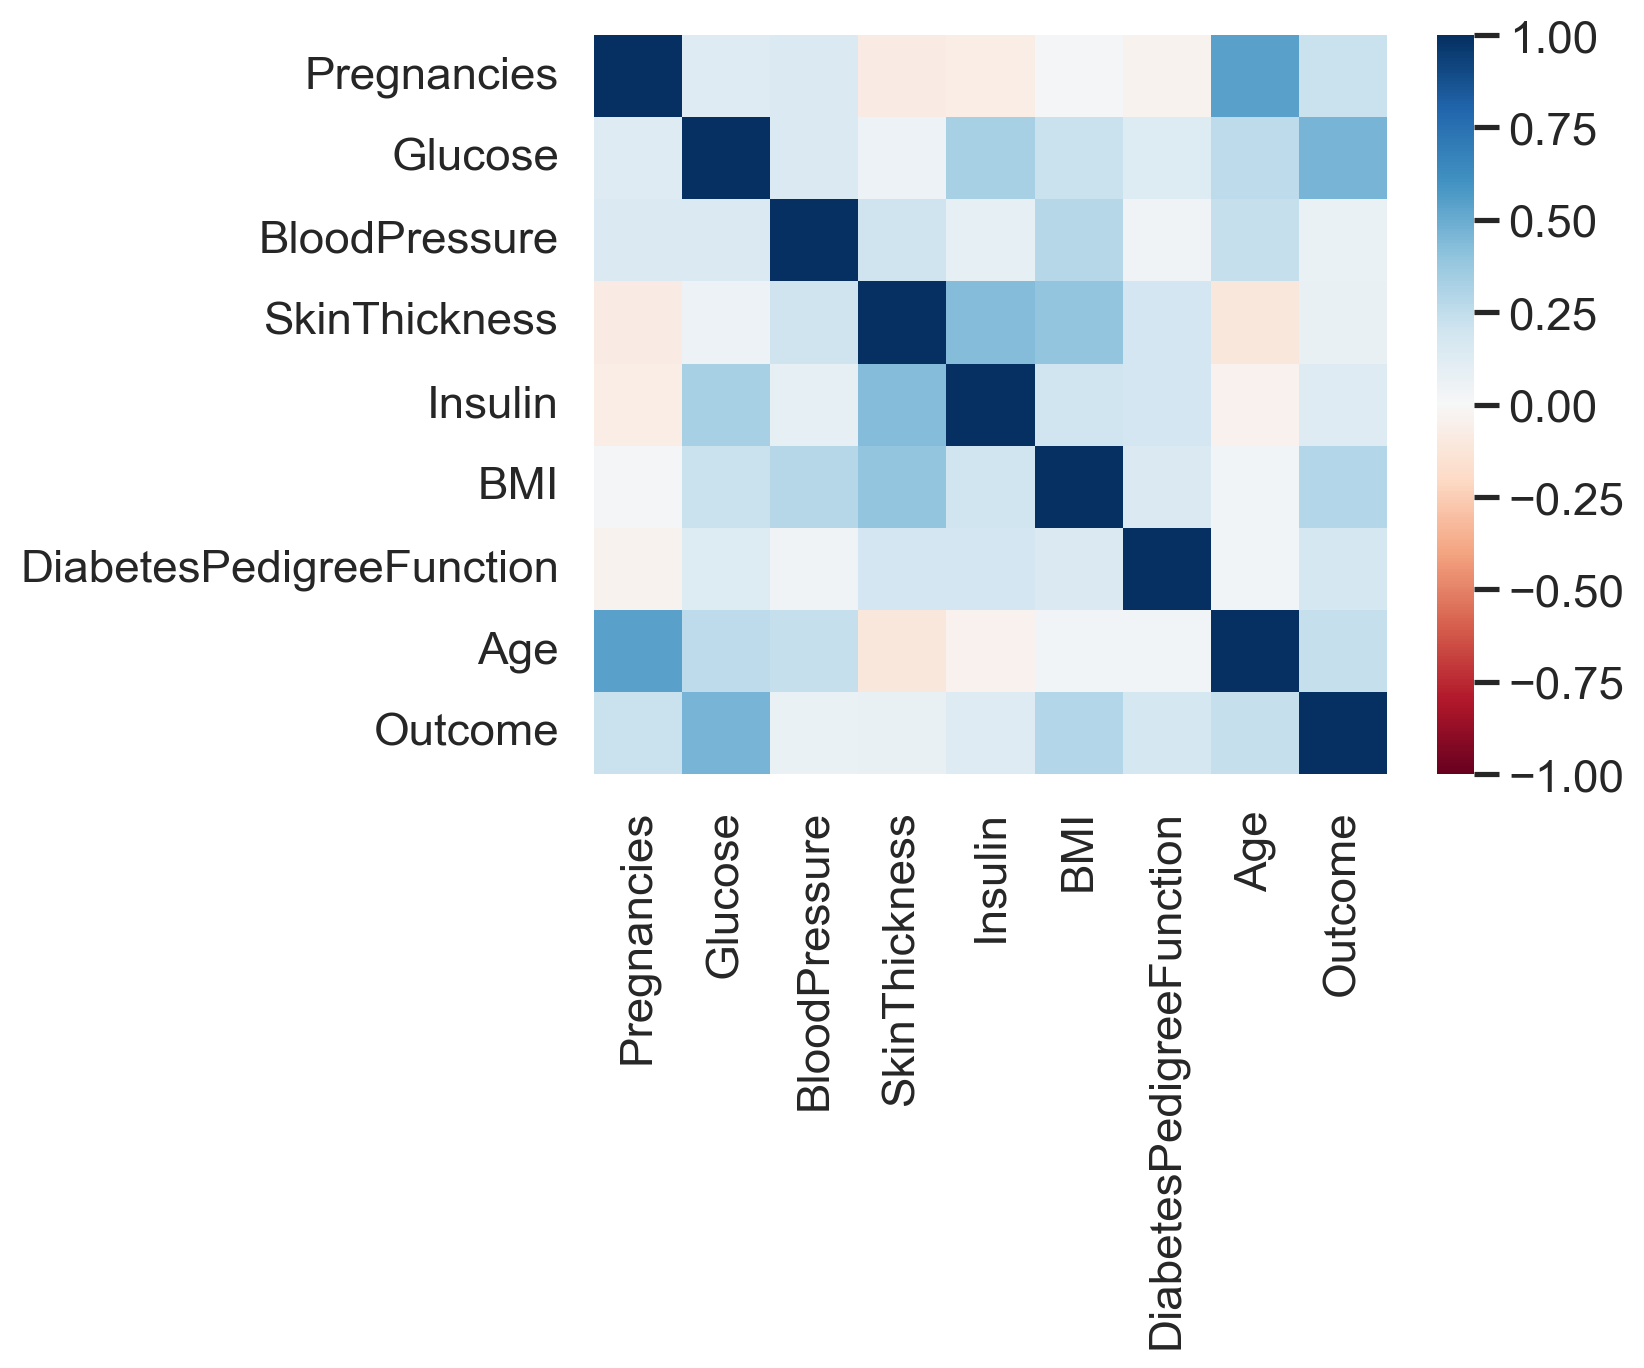

In [45]:
corr = df.corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap="RdBu");

So we can define some new models:
- Model 1: full model
- Model 2: omitting the non-significant variable
- Model 3: adding interactions for `Pregnancies` and `Age` and for `Insulin` and `SkinThickness`.

In [46]:
X2 = X_.drop(columns=['SkinThickness', 'Age', 'Insulin'])
result2 = sm.Logit(Y, X2).fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.474323
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      762
Method:                           MLE   Df Model:                            5
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.2667
Time:                        16:40:45   Log-Likelihood:                -364.28
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 3.442e-55
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.8609      0.096     -8.968      0.000      -1.049      -0.673
Pregnancies                  0.5172      0.094      5.514      0.000       0.333       0.701
Glucose                      1.1081      0.108     10.213      0.000       0.895       1.321
BloodPressure               -0.2324      0.097     -2.387      0.017      -0.423      -0.042
BMI                          0.6688      0.111      6.006      0.000       0.451       0.887
DiabetesPedigreeFunction     0.3017      0.097      3.097      0.002       0.111       0.493
============================================================================================
"""

In [53]:
X3 = X_.copy()
X3['Pregnancies*Age'] = X3['Pregnancies'] * X3['Age']
X3['Pregnancies*Age'] -= X3['Pregnancies*Age'].mean()
X3['Pregnancies*Age'] /= X3['Pregnancies*Age'].std()
result3 = sm.Logit(Y, X3).fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.465183
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      758
Method:                           MLE   Df Model:                            9
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.2808
Time:                        16:58:00   Log-Likelihood:                -357.26
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 7.503e-55
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.8971      0.099     -9.077      0.000      -1.091      -0.703
Pregnancies                  0.5696      0.121      4.714      0.000       0.333       0.806
Glucose                      1.1185      0.119      9.389      0.000       0.885       1.352
BloodPressure               -0.2435      0.101     -2.405      0.016      -0.442      -0.045
SkinThickness                0.0405      0.112      0.363      0.717      -0.178       0.260
Insulin                     -0.1227      0.106     -1.160      0.246      -0.330       0.085
BMI                          0.7127      0.120      5.934      0.000       0.477       0.948
DiabetesPedigreeFunction     0.3113      0.100      3.124      0.002       0.116       0.507
Age                          0.1972      0.111      1.778      0.075      -0.020       0.415
Pregnancies*Age             -0.3024      0.103     -2.934      0.003      -0.504      -0.100
============================================================================================
"""

We can compare the NLL of the three models (lower is better, this is our loss function).

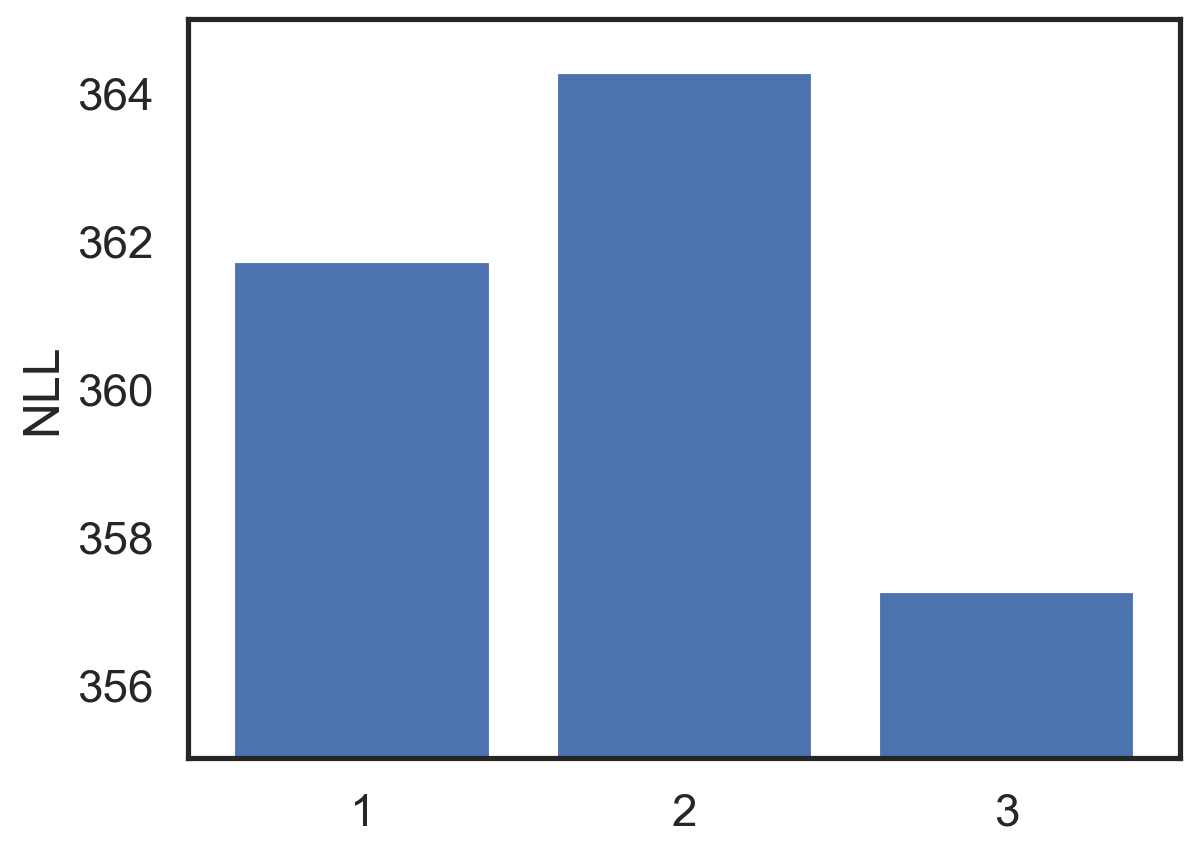

In [54]:
results = [result1, result2, result3]
plt.bar(['1', '2', '3'], [-res.llf for res in results])
plt.ylabel('NLL')
plt.ylim(355, 365);

We find that the NLL scales with the number of parameters, so we might be **over-fitting**.

We can instead compare the **AIC** (lower is better), which tries to balance between the goodness of fit (log likelihood, $\ell$) and the number of parameters ($k$):
$$
AIC = −2\ell+2\textit{k}
$$
A difference of 2 is usually considered enough to prefer a more complex model.

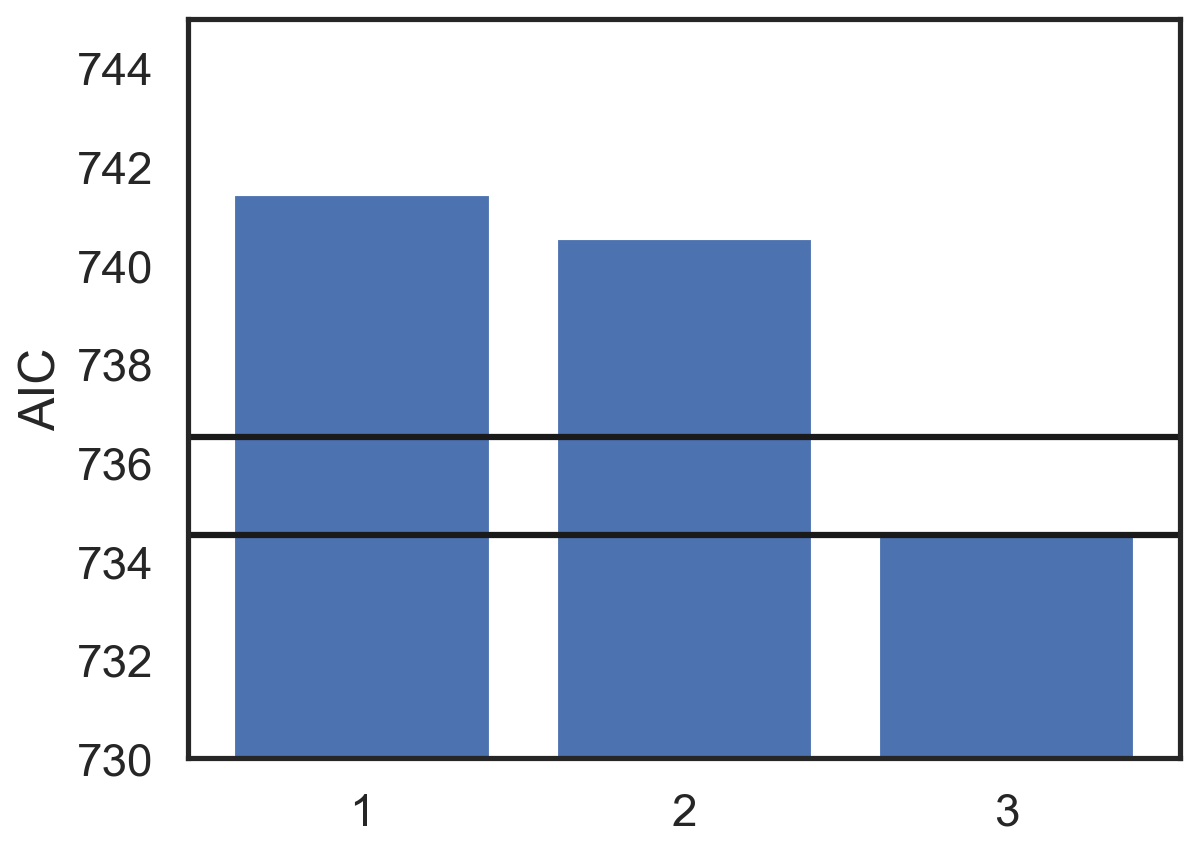

In [55]:
results = [result1, result2, result3]
AICs = np.array([res.aic for res in results])
plt.bar(['1', '2', '3'], AICs)
plt.ylabel('AIC')
plt.ylim(730, 745)
plt.axhline(np.min(AICs), color='k')
plt.axhline(np.min(AICs)+2 , color='k');

So indeed in this case we can say that model 3 has a better fit despite having more parameters and not because it has more parameters.

## Exercise 1

Instead of AIC, compare BIC, which uses the number of sample $n$ for the penalty term so when we have a lot of data ($n>e^2\approx 7.3$ the penalty for additional parameters is larger than in AIC,
$$
BIC = −2\ell + k \log n
$$

In [29]:
## your  code here 

You can see that this time model 2 (which has less parameters) is preferred.

## Exercise 2

Try to find another model that outperforms model 2 in terms of BIC. 
It can have less parameters, more parameters, whatever you want.
New features can be generated from existing ones using multiplication.
You can even take higher degrees of existing features; as long as the model is linear in the _parameters_, it is still a linear model.

In [ ]:
## your  code here 

# Generalized linear model

So in linear regression we use a normal distribution for the response $y$. In logistic regression we used a Bernoulli distribution for $y$ and a logit function for $\hat{y}$. 

These examples can be generalized to a framework called **generalized linear models (GLM)** (ProbNL ch. 12.)

$$z_i = \sum_{j=1}^{m}a_{i,j} x_j $$
$$\hat{y}_i = f(z_i) $$
$$y_i \sim \mathbf{D}(\hat{y}_i, \ldots)$$
where $D$ is a distribution (from the exponential family) and $f$ is a **link function**.

# References

- ProbML - [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html) by Kevin P. Murphy. Online version. June 26, 2024
- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.1**.
- Joshi, Ram D., and Chandra K. Dhakal. [_Predicting Type 2 Diabetes Using Logistic Regression and Machine Learning Approaches._](https://doi.org/10.3390/ijerph18147346) International Journal of Environmental Research and Public Health 18, no. 14 (July 9, 2021): 7346.


# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.